## Springboard Data Science Track Capstone Project 1
### Histopathologic Cancer Detection
### by Morgan Fry
### Data Exploration notebook


In [1]:
#includes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline

from matplotlib.image import imread
import cv2    

from sklearn.utils import shuffle
import pickle
import sys
import seaborn as sns

In [2]:
#load data saved in data wrangling notebook
y_s=pickle.load(open("y_s.p","rb"))
X_s=pickle.load(open("X_s.p","rb"))
X_s_vect=pickle.load(open("X_s_vect.p","rb"))
X_s_gray=pickle.load(open("X_s_gray.p","rb"))
X_s_gray_vect=pickle.load(open("X_s_gray_vect.p","rb"))

##### Let's look at a few of the samples, in color and in grayscale

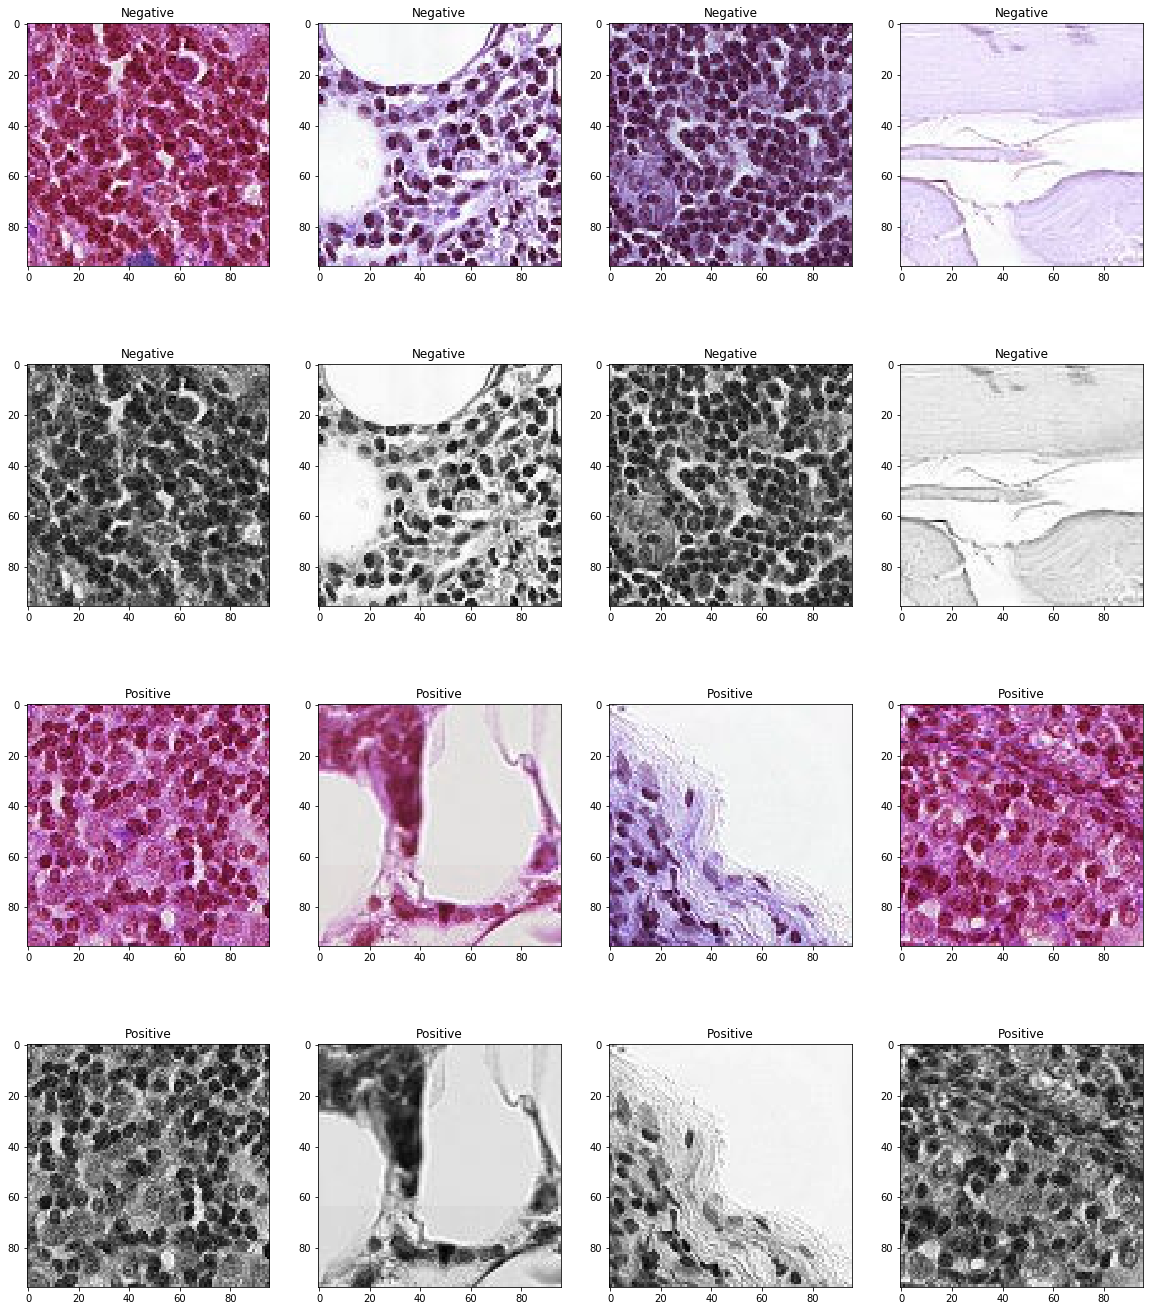

In [3]:
#select 8 at random
shuffled_y=shuffle(y_s)

fig,ax = plt.subplots(4,4, figsize=(20,24))

#4 negatives
for i, idx in enumerate(shuffled_y[shuffled_y['label'] == 0]['id'][:4]):
    ax[0,i].imshow(X_s.get(idx))
    ax[0,i].set_title('Negative')
    
#4 negatives grayscale
for i, idx in enumerate(shuffled_y[shuffled_y['label'] == 0]['id'][:4]):
    ax[1,i].imshow(X_s_gray.get(idx), cmap='gray')
    ax[1,i].set_title('Negative')
    
#4 positives
for i, idx in enumerate(shuffled_y[shuffled_y['label'] == 1]['id'][:4]):
    ax[2,i].imshow(X_s.get(idx))
    ax[2,i].set_title('Positive')
    

#4 positives grayscale
for i, idx in enumerate(shuffled_y[shuffled_y['label'] == 1]['id'][:4]):
    ax[3,i].imshow(X_s_gray.get(idx), cmap='gray')
    ax[3,i].set_title('Positive')
  

##### To begin looking for trends in the data, first we'll split into positive and negative groups in advance of plotting some features


In [12]:
y_pos=y_s[y_s.label == 1]
y_neg=y_s[y_s.label == 0]

In [20]:
X_pos=X_s.copy()
X_pos_vect=X_s_vect.copy()
X_pos_gray=X_s_gray.copy()
for idx,row in y_neg.iterrows():
    X_pos.pop(row['id'])
    X_pos_gray.pop(row['id'])
    X_pos_vect.pop(row['id'])

X_neg=X_s.copy()
X_neg_gray=X_s_gray.copy()
X_neg_vect=X_s_vect.copy()
for idx,row in y_pos.iterrows():
    X_neg.pop(row['id'])
    X_neg_gray.pop(row['id'])
    X_neg_vect.pop(row['id'])


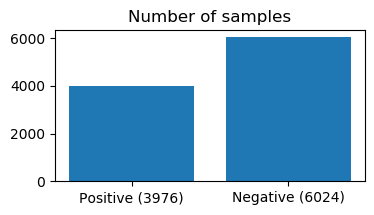

In [22]:
samples=[len(X_pos),len(X_neg)]

fig = plt.figure(figsize=(4, 2),dpi=100)
plt.bar([1,0], [len(X_neg),len(X_pos)])
plt.xticks([1,0],["Negative ({})".format(len(X_neg)),"Positive ({})".format(len(X_pos))])
plt.title("Number of samples")
plt.show()

##### First of all, we can notice that the training data contains about 60% negative and 40% positive samples.


The dataset is made up of images, so a few ways of exploring the data come to mind:
* intensity of each of the color channels
* aggregations of the channels


In [8]:
X_pos_gray_l=list(X_pos_gray.values())
X_neg_gray_l=list(X_neg_gray.values())
X_pos_gray_l=[np.ravel(each) for each in X_pos_gray_l]
X_neg_gray_l=[np.ravel(each) for each in X_neg_gray_l]

In [27]:
X_pos_l=list(X_pos.values())
X_neg_l=list(X_neg.values())
X_pos_vect_l=list(X_pos_vect.values())
X_neg_vect_l=list(X_neg_vect.values())

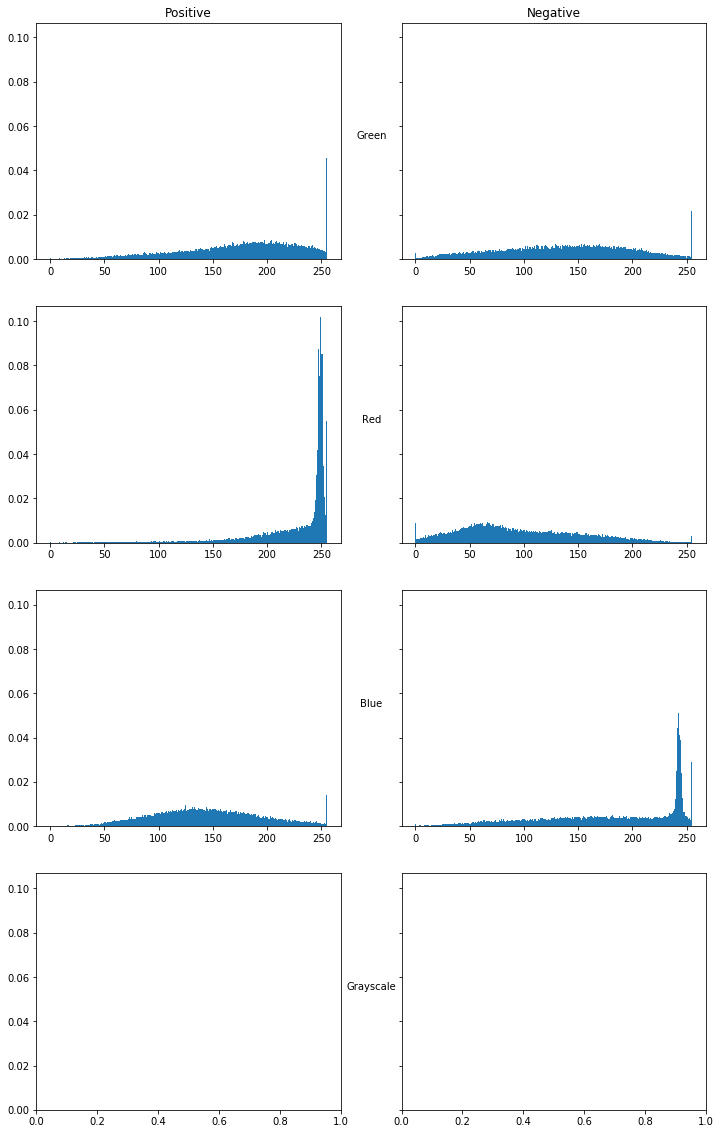

In [30]:
fig,ax = plt.subplots(4,2, sharey=True, figsize=(12,20))

ax[0,0].hist(X_pos_l[:][:][:][0].flatten(),density=True,bins=256)
ax[0,1].hist(X_neg_l[:][:][:][0].flatten(),density=True,bins=256)
ax[1,0].hist(X_pos_l[:][:][:][1].flatten(),density=True,bins=256)
ax[1,1].hist(X_neg_l[:][:][:][1].flatten(),density=True,bins=256)
ax[2,0].hist(X_pos_l[:][:][:][2].flatten(),density=True,bins=256)
ax[2,1].hist(X_neg_l[:][:][:][2].flatten(),density=True,bins=256)
#ax[3,0].hist(X_pos_gray_l,bins=256)
#ax[3,1].hist(X_neg_gray_l,bins=256)

ax[0,0].set_title("Positive")
ax[0,1].set_title("Negative")
ax[0,1].set_ylabel("Green",rotation='horizontal',labelpad=30)
ax[1,1].set_ylabel("Red",rotation='horizontal',labelpad=30)
ax[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=30)
ax[3,1].set_ylabel("Grayscale",rotation='horizontal',labelpad=30)

plt.show()

#### We can begin to see a difference in the distribution of color between positive and negative samples. Among the Positive group we see:
* Brighter green channel
* Brighter red channel, and many very bright red samples
* Dimmer blue channel

#### Also worth noting is the spike at the value '256' in every channel. This corresponds to the whitespace in the images (white is (256,256,256)).
#### Next we will examine the results of some aggregation to see if there is anything we can learn there.

In [75]:
#create some aggregates of the data
X_pos_mean=[np.mean(each) for each in X_pos_vect_l]
X_neg_mean=[np.mean(each) for each in X_neg_vect_l]
X_pos_med=[np.median(each) for each in X_pos_vect_l]
X_neg_med=[np.median(each) for each in X_neg_vect_l]

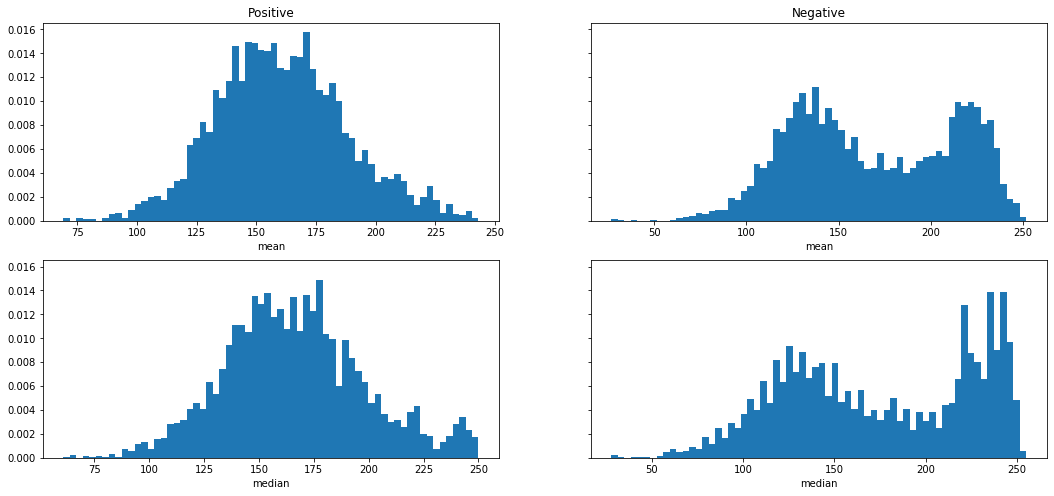

In [79]:
fig,axs = plt.subplots(2,2, sharey=True, figsize=(18,8))

axs[0,0].hist(X_pos_mean,bins=64,density=True)
axs[0,1].hist(x=X_neg_mean,bins=64,density=True)
axs[1,0].hist(X_pos_med,bins=64,density=True)
axs[1,1].hist(x=X_neg_med,bins=64,density=True)

axs[0,0].set_title("Positive")
axs[0,1].set_title("Negative")
axs[0,0].set_xlabel("mean")
axs[0,1].set_xlabel("mean")
axs[1,0].set_xlabel("median")
axs[1,1].set_xlabel("median")

plt.show()

###### There is a clear difference in the distribution of the mean values of the positive and negative sets.